# Tarea 6. Distribución óptima de capital y selección de portafolios.

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/en/f/f3/SML-chart.png" width="400px" height="400px" />

**Resumen.**
> En esta tarea, tendrás la oportunidad de aplicar los conceptos y las herramientas que aprendimos en el módulo 3. Específicamente, utilizarás técnicas de optimización media-varianza para construir la frontera de mínima varianza, encontrar el mejor portafolio sobre la frontera mínima varianza, y finalmente, identificar la asignación óptima de capital para un inversionista dado su nivel de averisón al riesgo.

**Criterio de revisión.**
> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

**Antes de comenzar.**
> Por favor, copiar y pegar este archivo en otra ubicación. Antes de comenzar, nombrarlo *Tarea6_ApellidoNombre*, sin acentos y sin espacios; por ejemplo, en mi caso el archivo se llamaría *Tarea6_JimenezEsteban*. Resolver todos los puntos en dicho archivo y subir en este espacio.

## 1. Datos (10 puntos)

Considere los siguientes datos de bonos, índice de acciones, mercados desarrollados, mercados emergentes, fondos privados, activos reales y activos libres de riesgo:

In [1]:
# Importamos pandas y numpy
import pandas as pd
import numpy as np

In [2]:
# Resumen en base anual de rendimientos esperados y volatilidades
annual_ret_summ = pd.DataFrame(columns=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real', 'Libre_riesgo'], index=['Media', 'Volatilidad'])
annual_ret_summ.loc['Media'] = np.array([0.0400, 0.1060, 0.0830, 0.1190, 0.1280, 0.0620, 0.0300])
annual_ret_summ.loc['Volatilidad'] = np.array([0.0680, 0.2240, 0.2210, 0.3000, 0.2310, 0.0680, None])

annual_ret_summ.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real,Libre_riesgo
Media,0.04,0.106,0.083,0.119,0.128,0.062,0.03
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068,None


In [3]:
# Matriz de correlación
corr = pd.DataFrame(data= np.array([[1.0000, 0.4000, 0.2500, 0.2000, 0.1500, 0.2000],
                                    [0.4000, 1.0000, 0.7000, 0.6000, 0.7000, 0.2000],
                                    [0.2500, 0.7000, 1.0000, 0.7500, 0.6000, 0.1000],
                                    [0.2000, 0.6000, 0.7500, 1.0000, 0.2500, 0.1500],
                                    [0.1500, 0.7000, 0.6000, 0.2500, 1.0000, 0.3000],
                                    [0.2000, 0.2000, 0.1000, 0.1500, 0.3000, 1.0000]]),
                    columns=annual_ret_summ.columns[:-1], index=annual_ret_summ.columns[:-1])
corr.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Bonos,1.00,0.4,0.25,0.20,0.15,0.20
Acciones,0.40,1.0,0.70,0.60,0.70,0.20
Desarrollado,0.25,0.7,1.00,0.75,0.60,0.10
Emergente,0.20,0.6,0.75,1.00,0.25,0.15
Privados,0.15,0.7,0.60,0.25,1.00,0.30
Real,0.20,0.2,0.10,0.15,0.30,1.00


1. Graficar en el espacio de rendimiento esperado contra volatilidad cada uno de los activos (10 puntos).

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Rendimiento esperado ($E[r]$)')

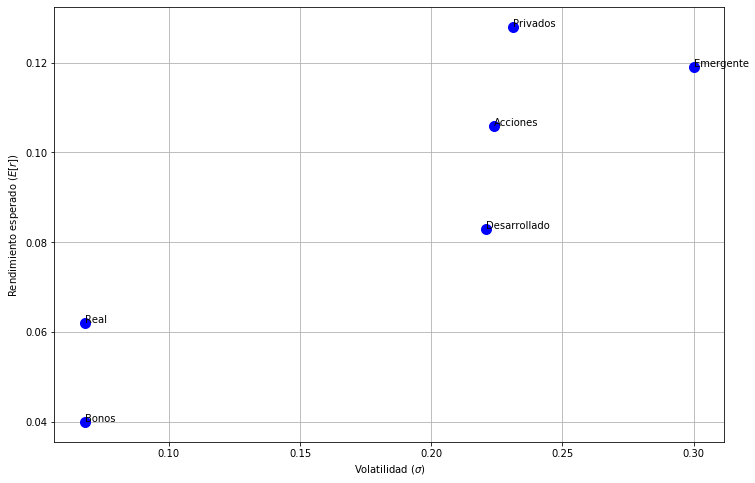

In [24]:
x_points=annual_ret_summ.T.loc[:,'Volatilidad']
y_points=annual_ret_summ.T.loc[:,'Media']

plt.figure(figsize=(12,8))
plt.plot(x_points,y_points,'ob',ms=10)
for i in range (0,6):
    plt.text(x_points[i], y_points[i],annual_ret_summ.T.index[i])
plt.grid()
plt.xlabel('Volatilidad ($\sigma$)')
plt.ylabel('Rendimiento esperado ($E[r]$)')

## 2. Hallando portafolios sobre la frontera de mínima varianza (35 puntos)

Usando los datos del punto anterior:

1. Halle los pesos del portafolio de mínima varianza considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
2. Halle los pesos del portafolio EMV considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
3. Halle la covarianza y la correlación entre los dos portafolios hallados (5 puntos)

### Punto #1

In [25]:
# Portafolio de minima varianza 
#Importar liberías 
from scipy.optimize import minimize 
annual_ret_sum=annual_ret_summ.drop(['Libre_riesgo'],axis=1)
annual_ret_sum

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Media,0.04,0.106,0.083,0.119,0.128,0.062
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068


In [26]:
#Rendimientos esperados de activos individuales
Er=annual_ret_sum.loc['Media',:].values

#Matriz de covarianzas 
S=np.diag(annual_ret_sum.loc['Volatilidad', :].values)
Sigma = S.dot(corr).dot(S)


In [27]:
# Función objetivo
def varianza(w, Sigma):
    return w.T.dot(Sigma).dot(w)

In [28]:
# Dato inicial
n=len(Er)
w0= np.ones(n)/n
# Cotas de las variables
bnds=((0,1), )*n
# Restricciones
cons = {'type':'eq', 'fun':lambda w: w.sum() - 1}

In [29]:
# Portafolio de mínima varianza
minvar=minimize(fun=varianza, x0=w0, args=(Sigma,), bounds=bnds, constraints=cons)
minvar

     fun: 0.0027745037325952863
     jac: array([0.00551408, 0.00912289, 0.00525779, 0.00714968, 0.00710235,
       0.0055834 ])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.95146500e-01, 0.00000000e+00, 2.09837058e-04, 4.33680869e-19,
       0.00000000e+00, 5.04643663e-01])

In [36]:
w_minvar=minvar.x
E_minvar=Er.T.dot(w_minvar)
s_minvar=(w_minvar.T.dot(Sigma).dot(w_minvar))**0.5
SR_minvar=(E_minvar-annual_ret_summ.loc['Media', 'Libre_riesgo'])/s_minvar

w_minvar, E_minvar, s_minvar, SR_minvar

(array([4.95146500e-01, 0.00000000e+00, 2.09837058e-04, 4.33680869e-19,
        0.00000000e+00, 5.04643663e-01]),
 0.0511111835712562,
 0.0526735581918982,
 0.4007928132431225)

In [65]:

ac = pd.DataFrame(columns=['Asignación de capital %'], index=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real'])
ac.loc['Bonos'] = w_minvar[0]*100
ac.loc['Acciones'] = w_minvar[1]*100
ac.loc['Desarrollado'] = w_minvar[2]*100
ac.loc['Emergente'] = w_minvar[3]*100
ac.loc['Privados'] = w_minvar[4]*100
ac.loc['Real'] = w_minvar[5]*100
ac

,Asignación de capital %
Bonos,49.5147
Acciones,0
Desarrollado,0.0209837
Emergente,4.33681e-17
Privados,0
Real,50.4644


In [75]:
mv = pd.DataFrame(columns=['%'], index=["Rendimiento esperado", "Volatilidad", "Cociente de Sharp"])
mv.loc['Rendimiento esperado'] = E_minvar*100
mv.loc['Volatilidad'] = s_minvar*100
mv.loc['Cociente de Sharp'] = SR_minvar*100
mv 

,%
Rendimiento esperado,5.11112
Volatilidad,5.26736
Cociente de Sharp,40.0793


### Punto 2

In [31]:
# Portafolio eficiente en media varainza (EMV)
# Función objetivo
def minus_SR(w, Sigma, Er, rf):
    Ep= Er.T.dot(w)
    sp=(w.T.dot(Sigma).dot(w))**0.5
    SR=(Ep - rf)/sp
    return -SR

In [32]:
# Dato inicial
n=len(Er)
w0= np.ones(n)/n
# Cotas de las variables
bnds=((0,1), )*n
# Restricciones
cons = {'type':'eq', 'fun':lambda w: w.sum() - 1}

In [33]:
# Portafolio EMV
EMV=minimize(fun=minus_SR, 
             x0=w0, 
             args=(Sigma, Er, annual_ret_summ.loc['Media', 'Libre_riesgo'] ), 
             bounds=bnds,
             constraints=cons)
EMV

     fun: -0.5811986201269204
     jac: array([-0.36522095, -0.28920724, -0.12258474, -0.36597763, -0.36617207,
       -0.36620118])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.34289953e-17, 1.01738175e-16, 1.23637069e-16, 8.19187951e-02,
       1.65859031e-01, 7.52222174e-01])

In [34]:
annual_ret_summ

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real,Libre_riesgo
Media,0.04,0.106,0.083,0.119,0.128,0.062,0.03
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068,None


In [35]:
# Pesos, rendimiento y riesgo del portafolio EMV
w_EMV=EMV.x
E_EMV=Er.T.dot(w_EMV)
s_EMV=(w_EMV.T.dot(Sigma).dot(w_EMV))**0.5
SR_EMV=(E_EMV-annual_ret_summ.loc['Media', 'Libre_riesgo'])/s_EMV

w_EMV, E_EMV, s_EMV, SR_EMV

(array([1.34289953e-17, 1.01738175e-16, 1.23637069e-16, 8.19187951e-02,
        1.65859031e-01, 7.52222174e-01]),
 0.0776160673678556,
 0.0819273579098611,
 0.5811986201269204)

In [66]:
ac2 = pd.DataFrame(columns=['Asignación de capital %'], index=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real'])
ac2.loc['Bonos'] = w_EMV[0]*100
ac2.loc['Acciones'] = w_EMV[1]*100
ac2.loc['Desarrollado'] = w_EMV[2]*100
ac2.loc['Emergente'] = w_EMV[3]*100
ac2.loc['Privados'] = w_EMV[4]*100
ac2.loc['Real'] = w_EMV[5]*100
ac2

,Asignación de capital %
Bonos,1.3429e-15
Acciones,1.01738e-14
Desarrollado,1.23637e-14
Emergente,8.19188
Privados,16.5859
Real,75.2222


In [74]:
emv = pd.DataFrame(columns=['%'], index=["Rendimiento esperado", "Volatilidad", "Cociente de Sharp"])
emv.loc['Rendimiento esperado'] = E_EMV*100
emv.loc['Volatilidad'] = s_EMV*100
emv.loc['Cociente de Sharp'] = SR_EMV*100
emv 

,%
Rendimiento esperado,7.76161
Volatilidad,8.19274
Cociente de Sharp,58.1199


### Punto #3

In [72]:
# covarianza y correlacion entre EMV y el portafolio de minima varianza
cov =w_EMV.T.dot(Sigma).dot(w_minvar)
corr=cov/(s_EMV*s_minvar)


In [73]:
cc = pd.DataFrame(columns=['%'], index=["Covarianza", "Correlacion"])
cc.loc['Covarianza'] = cov*100
cc.loc['Correlacion'] = corr*100
cc

,%
Covarianza,0.298182
Correlacion,69.0971


## 3. Frontera de mínima varianza y LAC (30 puntos)

Con los portafolios que se encontraron en el punto anterior (de mínima varianza y EMV):

1. Construya la frontera de mínima varianza calculando el rendimiento esperado y volatilidad para varias combinaciones de los anteriores portafolios. Reportar dichas combinaciones en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).
2. También construya la línea de asignación de capital entre el activo libre de riesgo y el portafolio EMV. Reportar las combinaciones de estos activos en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).

In [41]:
annual_ret_summ

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real,Libre_riesgo
Media,0.04,0.106,0.083,0.119,0.128,0.062,0.03
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068,None


In [38]:
# Vector de w
w = np.linspace(0, 3, 100)

In [40]:
# DataFrame de portafolios: 
portafolios = pd.DataFrame(data={'w': w, 
                                 '1-w': 1 - w,
                                 'Media': w * E_EMV + (1 - w) * E_minvar,
                                 'Vol': ((w * s_EMV)**2 + ((1 - w) * s_minvar)**2 + 2 * w * (1 - w) * cov)**0.5    
                                })
portafolios['RS'] = (portafolios['Media'] - 0.03) / portafolios['Vol']
portafolios.head()

,w,1-w,Media,Vol,RS
0,0.000000,1.000000,0.051111,0.052674,0.400793
1,0.030303,0.969697,0.051914,0.052823,0.414861
2,0.060606,0.939394,0.052718,0.053034,0.428360
3,0.090909,0.909091,0.053521,0.053304,0.441256
4,0.121212,0.878788,0.054324,0.053633,0.453523


In [43]:
#Dataframe con pesos, ER, volatilidad y SR
LAC=pd.DataFrame(data={'wp': w,
                       'wrf':1-w,
                       'Media': w*E_EMV+(1-w)*annual_ret_summ.loc['Media', 'Libre_riesgo'],
                       'Vol': w*s_EMV,
                              })
LAC['SR']=(LAC['Media']-0.03)/LAC['Vol']
LAC.head()

,wp,wrf,Media,Vol,SR
0,0.000000,1.000000,0.030000,0.000000,NaN
1,0.030303,0.969697,0.031443,0.002483,0.581199
2,0.060606,0.939394,0.032886,0.004965,0.581199
3,0.090909,0.909091,0.034329,0.007448,0.581199
4,0.121212,0.878788,0.035772,0.009931,0.581199


## 4. Gráficos y conclusiones (25 puntos)

1. Usando todos los datos obtenidos, grafique:
 - los activos individuales,
 - portafolio de mínima varianza,
 - portafolio eficiente en media-varianza (EMV),
 - frontera de mínima varianza, y
 - línea de asignación de capital,
en el espacio de rendimiento (eje $y$) vs. volatilidad (eje $x$). Asegúrese de etiquetar todo y poner distintos colores para diferenciar los distintos elementos en su gráfico (15 puntos).
2. Suponga que usted está aconsejando a un cliente cuyo coeficiente de aversión al riesgo resultó ser 4. ¿Qué asignación de capital le sugeriría?, ¿qué significa su resultado?(10 puntos)

### Punto #1

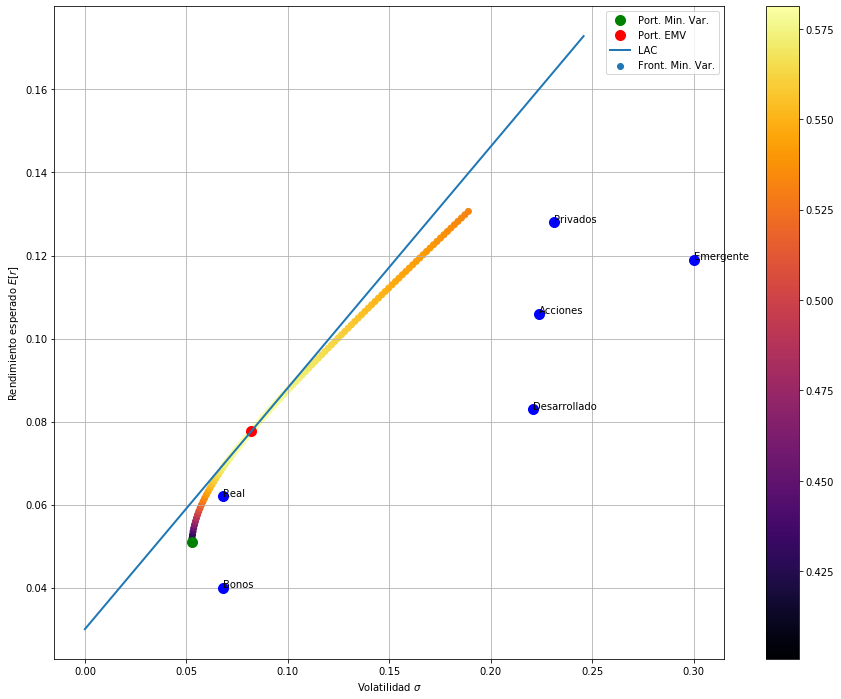

In [57]:
# Gráfica de dispersión de puntos coloreando 
# de acuerdo a SR, los activos individuales
# y los portafolios hallados
plt.figure(figsize=(15, 12))
plt.scatter(portafolios['Vol'], portafolios['Media'], c=portafolios['RS'], cmap='inferno', label='Front. Min. Var.')
plt.plot(s_minvar, E_minvar, 'og', ms=10, label='Port. Min. Var.')
plt.plot(s_EMV, E_EMV, 'or', ms=10, label='Port. EMV')
plt.plot(LAC['Vol'], LAC['Media'], lw=2, label='LAC')
plt.plot(x_points,y_points,'ob',ms=10)
for i in range (0,6):
    plt.text(x_points[i], y_points[i],annual_ret_summ.T.index[i])
plt.legend(loc='best')
plt.colorbar()
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")
plt.grid()


### Punto #2

In [77]:
g=4
w_a=(E_EMV-0.03)/(g*s_EMV**2)
w_a1=w_a*w_EMV
w_a1, 1-w_a

(array([2.38165666e-17, 1.80434498e-16, 2.19272585e-16, 1.45284469e-01,
        2.94153999e-01, 1.33407967e+00]),
 -0.7735181353168143)

In [83]:
# Asignacion de capital 
a_c = pd.DataFrame(columns=['Asignación de capital %'], index=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real',"Total"])
a_c.loc['Bonos'] = w_a1[0]*100
a_c.loc['Acciones'] = w_a1[1]*100
a_c.loc['Desarrollado'] = w_a1[2]*100
a_c.loc['Emergente'] = w_a1[3]*100
a_c.loc['Privados'] = w_a1[4]*100
a_c.loc['Real'] = w_a1[5]*100
a_c.loc['Total'] = np.sum(w_a1)*100
a_c


,Asignación de capital %
Bonos,2.38166e-15
Acciones,1.80434e-14
Desarrollado,2.19273e-14
Emergente,14.5284
Privados,29.4154
Real,133.408
Total,177.352


In [82]:
k = np.sum(w_a1)
k

1.7735181353168146

El total que nos aparecio fue un 177.35%. Lo anterior implica una posición corta en el activo libre de riesgo (suponiendo que se puede) y una posición larga (de más del 100%) en el mercado de activos: apalancamiento. Esto significa que el activo libre de riesgo debe ser apalancado con un 77.35%.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>